참고자료
https://www.kaggle.com/chengzhong9203/deepfm

In [56]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf

     |████████████████████████████████| 380.5MB 47kB/s 
     |████████████████████████████████| 501kB 47.0MB/s 
     |████████████████████████████████| 4.3MB 50.1MB/s 


In [0]:
BATCHSIZE = 2**12
EPOCHS = 2
LR = 1e-3
NRUNS = 5

import numpy as np
import pandas as pd
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate
from keras.layers import BatchNormalization, SpatialDropout1D, GaussianDropout, merge
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
import gc
import psutil
import os

#print(os.listdir("../input"))

In [0]:

import tensorflow as tf

In [0]:
process = psutil.Process(os.getpid())

In [5]:
train = pd.read_csv('/content/drive/My Drive/RS/RSstudy_train.csv') 
train['event_datetime'] = pd.to_datetime(train['event_datetime'])
train['day'] = train['event_datetime'].dt.dayofweek
train['hour'] = train['event_datetime'].dt.hour
train.head()

,event_datetime,bid_id,ssp_id,campaign_id,adset_id,placement_type,media_id,media_name,media_bundle,media_domain,publisher_id,publisher_name,device_ifa,device_os,device_os_version,device_model,device_carrier,device_make,device_connection_type,device_language,device_country,device_region,device_city,advertisement_id,click,day,hour
0,2019-10-04 03:33:52.764,xMzbNCw85v,SrN77Arvqh,82zKi1kf2g,I17zipTXx9,1pcQ3RJgQt,hkFCnTpDpn,Xbdchs5uK3,6Abk3Aq818,pjBT3sDGbH,FpOvhbPDXd,BnqjbSLXhH,7anfHnQbAH,TG14pLUXCY,aU9KSuwh6B,nz5kFLSj4p,wrzW2uRaKh,rp6gWKT7zk,Hx7e3tE5mu,8GSkINt29e,PCCn9Q1m20,EdsKnCCtPO,e7JXTJQ5Qw,7dyzy9aZoJ,0,4,3
1,2019-10-10 01:46:00.829,2zYNhNhTQJ,M6QaRvdZ8h,pxI7AewpTQ,QbQG0xVwEZ,kIeE1J0KCa,EWk3Gkflnz,Uk5MGt9vxz,DldwurRI4R,pjBT3sDGbH,vjSjiBHBO7,5OMeFjJ4Ij,1KohHujeG1,TG14pLUXCY,V7LhUlY53m,KBowLApKOt,bJ0VstP9sA,rp6gWKT7zk,WCK2G73H3A,LXYiFbLmMp,PCCn9Q1m20,Ik4H8OeSjh,poDvOHlRd9,B12nM0QBme,0,3,1
2,2019-10-07 00:28:32.185,QH9NvJYYH8,M6QaRvdZ8h,taRA9jVfVL,c5JbIqpgaH,kIeE1J0KCa,bqDiYyfa3T,SjZ9Dgg3gy,LfFPsJWJSf,pjBT3sDGbH,vjSjiBHBO7,vwL3b3oa2z,KDC1k92iSY,TG14pLUXCY,0D4DvtralJ,De08PwksoR,bJ0VstP9sA,rp6gWKT7zk,WCK2G73H3A,LXYiFbLmMp,PCCn9Q1m20,aI9W3Httpm,uuYScbMuRa,TbkcVoisoR,0,0,0
3,2019-10-06 14:54:39.124,DZx7H4WnWp,nwf1A3O5cO,s28CY2nINY,0QiIYS1fQc,kIeE1J0KCa,j7H2fWftrL,Uk5MGt9vxz,DldwurRI4R,pjBT3sDGbH,u8sVI0rp7b,w0Hd4CHeHj,5duZZKkd64,TG14pLUXCY,V7LhUlY53m,GN0GNqM49Q,kvNzH5Iavg,javoIwtGqV,aEmZFzgDfq,LXYiFbLmMp,PCCn9Q1m20,EdsKnCCtPO,e7JXTJQ5Qw,7dyzy9aZoJ,0,6,14
4,2019-10-08 14:00:05.404,X8kVGfRvAZ,y7QKxSwhwV,5GW7KdbnMO,cqZeAVmpDz,tg9mzu7kFm,NP4izPkoNR,TLifdirfbC,sddf8OR6Dn,pjBT3sDGbH,VYIqg0nIBd,BnqjbSLXhH,9xOhzfc8IA,TG14pLUXCY,0D4DvtralJ,ze9k4RJrzB,QqkQ9NitvB,javoIwtGqV,aEmZFzgDfq,LXYiFbLmMp,PCCn9Q1m20,p0bPp818iq,23nWfTpNyg,qTUiMFHa1k,0,1,14


In [6]:
test = pd.read_csv('/content/drive/My Drive/RS/RSstudy_test.csv') 
test['event_datetime'] = pd.to_datetime(test['event_datetime'])
test['day'] = test['event_datetime'].dt.dayofweek
test['hour'] = test['event_datetime'].dt.hour
test.head()

,event_datetime,bid_id,ssp_id,campaign_id,adset_id,placement_type,media_id,media_name,media_bundle,media_domain,publisher_id,publisher_name,device_ifa,device_os,device_os_version,device_model,device_carrier,device_make,device_connection_type,device_language,device_country,device_region,device_city,advertisement_id,day,hour
0,2019-10-10 13:48:34.408,LuTJ6GA6To,nwf1A3O5cO,HwI3fRmwXj,mFHpxA9Cyf,kIeE1J0KCa,sRqCheOKW4,n0p3m00ieQ,LfFPsJWJSf,pjBT3sDGbH,dShknap9uf,N8djnVWnYo,liooc6ac94,TG14pLUXCY,0D4DvtralJ,LovhexqLn0,bJ0VstP9sA,javoIwtGqV,WCK2G73H3A,LXYiFbLmMp,PCCn9Q1m20,EdsKnCCtPO,e7JXTJQ5Qw,xDjSV8yqPL,3,13
1,2019-10-09 02:02:09.640,VsqiBli7hG,SrN77Arvqh,ULkQIBSnFK,jR1GQ2Zxav,1pcQ3RJgQt,hkFCnTpDpn,Xbdchs5uK3,8mgoNdkMSC,pjBT3sDGbH,FpOvhbPDXd,BnqjbSLXhH,nNpBNXt2kR,TG14pLUXCY,aU9KSuwh6B,nz5kFLSj4p,wrzW2uRaKh,rp6gWKT7zk,Hx7e3tE5mu,8GSkINt29e,PCCn9Q1m20,EdsKnCCtPO,e7JXTJQ5Qw,7Jed7iZc4g,2,2
2,2019-10-08 06:10:51.252,gKecX9ZO0B,SrN77Arvqh,4hiRwnngGA,2G661f1fDv,1pcQ3RJgQt,hkFCnTpDpn,Xbdchs5uK3,WQ6W4pDG1v,pjBT3sDGbH,FpOvhbPDXd,BnqjbSLXhH,P6Xb48Hagq,TG14pLUXCY,aU9KSuwh6B,nz5kFLSj4p,wrzW2uRaKh,rp6gWKT7zk,Hx7e3tE5mu,8GSkINt29e,PCCn9Q1m20,EdsKnCCtPO,e7JXTJQ5Qw,tmj7wCMWB5,1,6
3,2019-10-09 11:35:14.366,a66lwEgDdo,Uox85xVMSC,meUJLsYxHq,tVJk5DJcI6,kIeE1J0KCa,9o8vIBOQ7q,n7ncYJrEcR,kYqxG9ZfVy,pjBT3sDGbH,bxQHU0czpC,5rkUXR5c8t,U895q81pdW,TG14pLUXCY,0D4DvtralJ,FI4J9704Kn,kvNzH5Iavg,javoIwtGqV,aEmZFzgDfq,LXYiFbLmMp,PCCn9Q1m20,p0bPp818iq,50j7YQMZbt,RDcrDg5GGQ,2,11
4,2019-10-01 22:44:33.302,PW96KQyTBC,nwf1A3O5cO,6MHXVqZ5r7,48oN7Ujd5Q,kIeE1J0KCa,j7H2fWftrL,Uk5MGt9vxz,DldwurRI4R,pjBT3sDGbH,u8sVI0rp7b,w0Hd4CHeHj,MzwnZIV8hy,TG14pLUXCY,V7LhUlY53m,KBowLApKOt,bJ0VstP9sA,javoIwtGqV,WCK2G73H3A,LXYiFbLmMp,PCCn9Q1m20,EdsKnCCtPO,e7JXTJQ5Qw,K6ZwviDgnR,1,22


Deepfm에 넣을 category변수

* device_ifa
* ssp_id
* campaign_id, adset_id
* media_id, media_name, media_bundle, media_domain
* publisher_id, publisher_name
* device_os_version, device_model, device_carrier, device_make, device_language, *device_region, device_city
* advertisement_id

In [0]:
##### THE TRAINING DATA #####

def get_keras_data(dataset):
    X = {
        'device_ifa': np.array(dataset.device_ifa),
        'ssp_id': np.array(dataset.ssp_id),
        'campaign_id': np.array(dataset.campaign_id),
        'adset_id': np.array(dataset.adset_id),
        'media_id': np.array(dataset.media_id),
        'media_name': np.array(dataset. media_name),
        'media_bundle': np.array(dataset. media_bundle),
        'media_domain': np.array(dataset.media_domain),
        'publisher_id': np.array(dataset.publisher_id),
        'publisher_name': np.array(dataset.publisher_name),
        'device_os_version': np.array(dataset.device_os_version),
        'device_model,': np.array(dataset.device_model),
        'device_carrier': np.array(dataset.device_carrier),
        'device_make': np.array(dataset.device_make),
        'device_language': np.array(dataset.device_language),
        'device_region': np.array(dataset.device_region),
        'device_city': np.array(dataset.device_city),
        'advertisement_id': np.array(dataset.advertisement_id)
    }
    return X

In [8]:
df = get_keras_data(train)
df

{'adset_id': array(['I17zipTXx9', 'QbQG0xVwEZ', 'c5JbIqpgaH', ..., '6eXmx32jU1',
        'LW6uvT0klj', 'uvnFjKs4Jq'], dtype=object),
 'advertisement_id': array(['7dyzy9aZoJ', 'B12nM0QBme', 'TbkcVoisoR', ..., 'B12nM0QBme',
        'CCWN3Vsn9P', '7Jed7iZc4g'], dtype=object),
 'campaign_id': array(['82zKi1kf2g', 'pxI7AewpTQ', 'taRA9jVfVL', ..., 'sq3efqRU7U',
        'LB5vz0I3MT', 'BC0lIET6CK'], dtype=object),
 'device_carrier': array(['wrzW2uRaKh', 'bJ0VstP9sA', 'bJ0VstP9sA', ..., 'PH0EDk0nOb',
        'wrzW2uRaKh', 'wrzW2uRaKh'], dtype=object),
 'device_city': array(['e7JXTJQ5Qw', 'poDvOHlRd9', 'uuYScbMuRa', ..., 'PWrH2XLwY1',
        'e7JXTJQ5Qw', 'AuJJyccWuD'], dtype=object),
 'device_ifa': array(['7anfHnQbAH', '1KohHujeG1', 'KDC1k92iSY', ..., 'AGm7kst73O',
        'bdsvGhSAK7', 'ponDqZuI4i'], dtype=object),
 'device_language': array(['8GSkINt29e', 'LXYiFbLmMp', 'LXYiFbLmMp', ..., 'LXYiFbLmMp',
        '8GSkINt29e', 'LXYiFbLmMp'], dtype=object),
 'device_make': array(['rp6gWKT7zk', 'rp

In [0]:
def get_data(column) :
    
    vocab = {}
    num = 0

    for i in np.hstack([train[column], test[column]]): 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in train[column]]
    encoded_d = [vocab[i] for i in test[column]]
    
    return encoded, encoded_d, num, vocab                   #train 인코딩, test 인코딩, 총 개수, 이름

In [10]:
import time
startTime = time.time()

encoded_device_ifa,encoded_device_ifa_test, num_device_ifa, vocab_device_ifa = get_data('device_ifa')

encoded_ssp_id,encoded_ssp_id_test, num_ssp_id, vocab_ssp_id = get_data('ssp_id')

encoded_campaign_id,encoded_campaign_id_test, num_campaign_id, vocab_campaign_id = get_data('campaign_id')
encoded_adset_id, encoded_adset_id_test, num_adset_id, vocab_adset_id = get_data('adset_id')

encoded_media_name, encoded_media_name_test, num_media_name, vocab_media_name = get_data('media_name')
encoded_media_bundle, encoded_media_bundle_test, num_media_bundle, vocab_media_bundle = get_data('media_bundle')
encoded_media_domain, encoded_media_domain_test, num_media_domain, vocab_media_domain = get_data('media_domain')

encoded_publisher_id, encoded_publisher_id_test, num_publisher_id, vocab_publisher_id = get_data('publisher_id')

encoded_device_model, encoded_device_model_test, num_device_model, vocab_device_model = get_data('device_model')
encoded_device_carrier, encoded_device_carrier_test, num_device_carrier, vocab_device_carrier = get_data('device_carrier')
encoded_device_make, encoded_device_make_test, num_device_make, vocab_device_make = get_data('device_make')
encoded_device_city, encoded_device_city_test, num_device_city, vocab_device_city = get_data('device_city')

encoded_advertisement_id, encoded_advertisement_id_test, num_advertisement_id, vocab_advertisement_id = get_data('advertisement_id')

encoded_placement_type, encoded_placement_type_test, num_placement_type, vocab_placement_type = get_data('placement_type')
encoded_device_os,encoded_device_os_test, num_device_os, vocab_device_os = get_data('device_os')
encoded_device_connection_type, encoded_device_connection_type_test, num_device_connection_type, vocab_device_connection_type = get_data('device_connection_type')

endTime = time.time() - startTime
print(endTime) 

22.909671306610107


In [11]:
# Input variables
device_ifa = Input(shape=(1,), dtype='int64', name = 'device_ifa')

ssp_id = Input(shape=(1,), dtype='int64', name = 'ssp_id')

campaign_id = Input(shape=(1,), dtype='int64', name = 'campaign_id')
adset_id = Input(shape=(1,), dtype='int64', name = 'adset_id')

media_name = Input(shape=(1,), dtype='int64', name = 'media_name')
media_bundle = Input(shape=(1,), dtype='int64', name = 'media_bundle')
media_domain = Input(shape=(1,), dtype='int64', name = 'media_domain')

publisher_id = Input(shape=(1,), dtype='int64', name = 'publisher_id')

device_model = Input(shape=(1,), dtype='int64', name = 'device_model')
device_carrier = Input(shape=(1,), dtype='int64', name = 'device_carrier')
device_make = Input(shape=(1,), dtype='int64', name = 'device_make')
device_city = Input(shape=(1,), dtype='int64', name = 'device_city')

advertisement_id = Input(shape=(1,), dtype='int64', name = 'advertisement_id')

In [12]:

#### THE MODEL ####

n_factors = 8
dense_n1 = 1000
dense_n2 = 1400
dense_n3 = 200
dense_n4 = 40

emb_device_ifa = Embedding(input_dim = num_device_ifa, output_dim = n_factors, 
                              name = 'emb_device_ifa', input_length=1)(device_ifa)

emb_ssp_id = Embedding(input_dim = num_ssp_id, output_dim = n_factors,
                              name = 'emb_ssp_id', input_length=1)(ssp_id)   

emb_campaign_id = Embedding(input_dim = num_campaign_id, output_dim = n_factors,
                              name = 'emb_campaign_id', input_length=1)(campaign_id)  
emb_adset_id = Embedding(input_dim = num_adset_id, output_dim = n_factors, 
                              name = 'emb_adset_id', input_length=1)(adset_id)

emb_media_name = Embedding(input_dim = num_media_name, output_dim = n_factors, 
                              name = 'emb_media_name', input_length=1)(media_name)
emb_media_bundle= Embedding(input_dim = num_media_bundle, output_dim = n_factors,
                              name = 'emb_media_bundle', input_length=1)(media_bundle)   
emb_media_domain = Embedding(input_dim = num_media_domain, output_dim = n_factors,
                              name = 'emb_media_domain', input_length=1)(media_domain)  

emb_publisher_id = Embedding(input_dim = num_publisher_id, output_dim = n_factors, 
                              name = 'emb_publisher_id', input_length=1)(publisher_id)

emb_device_model = Embedding(input_dim = num_device_model, output_dim = n_factors, 
                              name = 'emb_device_model', input_length=1)(device_model)
emb_device_carrier = Embedding(input_dim = num_device_carrier, output_dim = n_factors,
                              name = 'emb_device_carrier', input_length=1)(device_carrier)   
emb_device_make = Embedding(input_dim = num_device_make, output_dim = n_factors,
                              name = 'emb_device_make', input_length=1)(device_make)  
emb_device_city = Embedding(input_dim = num_device_city, output_dim = n_factors,
                              name = 'emb_device_city', input_length=1)(device_city)  

emb_advertisement_id = Embedding(input_dim = num_advertisement_id, output_dim = n_factors,
                              name = 'emb_advertisement_id', input_length=1)(advertisement_id)  

In [13]:
emb_layers = [(emb_device_ifa), (emb_ssp_id), (emb_campaign_id), (emb_adset_id), (emb_media_name), (emb_media_bundle),
              (emb_media_domain), (emb_publisher_id), (emb_device_model), (emb_device_carrier), (emb_device_make), (emb_device_city), (emb_advertisement_id)]

fe = concatenate(emb_layers)
embs = GaussianDropout(0.2)(fe)
embs = Flatten()(embs)

In [14]:
embs

<tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>

In [0]:
#%% DEEP PART
x = embs
x = (BatchNormalization())(x)
x = GaussianDropout(0.2)(Dense(dense_n1,activation='relu')(x))
x = (BatchNormalization())(x)
x = GaussianDropout(0.3)(Dense(dense_n2,activation='relu')(x))
x = (BatchNormalization())(x)
x = GaussianDropout(0.25)(Dense(dense_n3,activation='relu')(x))
x = (BatchNormalization())(x)
deep_out = GaussianDropout(0.2)(Dense(dense_n4,activation='relu')(x))

In [16]:
deep_out

<tf.Tensor 'gaussian_dropout_5/cond/Merge:0' shape=(?, 40) dtype=float32>

In [0]:
#%% FM PART
import keras

first_order = [Flatten()(emb1) for emb1 in emb_layers]

from itertools import combinations

second_order = []

for emb1, emb2 in combinations(emb_layers, 2):
  dot_layer = keras.layers.dot([Flatten()(emb1),Flatten()(emb2)],axes=1)
  second_order.append(dot_layer)

In [0]:
first_order = keras.layers.add(first_order) 
second_order = keras.layers.add(second_order)

In [0]:
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/RS', monitor='val_loss',
                                verbose=1, save_best_only=True)

In [0]:
# def auc(y_true, y_pred):
#     auc = tf.metrics.auc(y_true, y_pred)[1]
#     K.get_session().run(tf.local_variables_initializer())
#     return auc                   -> 오류?

import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)   # tf.py_func : 텐서플로에 새롭게 만든 연산을 사용


In [0]:
#%% TOTAL



total_out = concatenate([(deep_out), (first_order), (second_order)])
outp = Dense(1,activation='sigmoid')(total_out)

model = Model(inputs=[device_ifa, ssp_id, campaign_id, adset_id, media_name,
                      media_bundle, media_domain, publisher_id, device_model, device_carrier, device_make, device_city,
                      advertisement_id], outputs=outp)

model.compile(loss='binary_crossentropy',optimizer=Adam(lr=LR),metrics=[auroc])

model.summary()

In [76]:
history = model.fit(x=[encoded_device_ifa, encoded_ssp_id, encoded_campaign_id, encoded_adset_id, 
                       encoded_media_name, encoded_media_bundle, encoded_media_domain, 
                       encoded_publisher_id, encoded_device_model, encoded_device_carrier, 
                       encoded_device_make,  encoded_device_city, encoded_advertisement_id],
                    y=train['click'], batch_size=2048, epochs=5, validation_split=0.005,verbose=1)


Train on 4378000 samples, validate on 22000 samples
Epoch 1/5
4378000/4378000 [==============================] - 111s 25us/step - loss: 0.1245 - auroc: 0.9669 - val_loss: 0.3692 - val_auroc: 0.7890
Epoch 2/5
4378000/4378000 [==============================] - 111s 25us/step - loss: 0.1202 - auroc: 0.9692 - val_loss: 0.4392 - val_auroc: 0.7757
Epoch 3/5
4378000/4378000 [==============================] - 111s 25us/step - loss: 0.1165 - auroc: 0.9712 - val_loss: 0.4316 - val_auroc: 0.7737
Epoch 4/5
4378000/4378000 [==============================] - 110s 25us/step - loss: 0.1131 - auroc: 0.9730 - val_loss: 0.4406 - val_auroc: 0.7750
Epoch 5/5
4378000/4378000 [==============================] - 110s 25us/step - loss: 0.1098 - auroc: 0.9746 - val_loss: 0.4539 - val_auroc: 0.7711


In [0]:
# 모델 저장하기 
model.save('model_deepfm.h5')
## model weight 불러오는법
# model.load_weights('model_1.h5')

In [79]:
import time
startTime = time.time()

a = model.predict([encoded_device_ifa_test, encoded_ssp_id_test, encoded_campaign_id_test, encoded_adset_id_test, 
                       encoded_media_name_test, encoded_media_bundle_test, encoded_media_domain_test, 
                       encoded_publisher_id_test, encoded_device_model_test, encoded_device_carrier_test, 
                       encoded_device_make_test,  encoded_device_city_test, encoded_advertisement_id])

endTime = time.time() - startTime
print(endTime) 

253.69408893585205


In [80]:
test_t = test[['bid_id']]
test_t['click'] = a
print('최대값', test_t.click.max())
test_t

최대값 1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,bid_id,click
0,LuTJ6GA6To,3.518670e-01
1,VsqiBli7hG,2.883077e-04
2,gKecX9ZO0B,3.401950e-02
3,a66lwEgDdo,1.949310e-02
4,PW96KQyTBC,5.462623e-02
...,...,...
1099995,JwkEnS3U26,4.440546e-06
1099996,RiM1zQdaQa,1.788139e-07
1099997,bEV8C6D3ls,2.167821e-04
1099998,k0hRNmP7t9,3.863614e-01


In [0]:
test_t.to_csv('sub__.csv',index=False)

In [85]:
os.getcwd()

'/content'

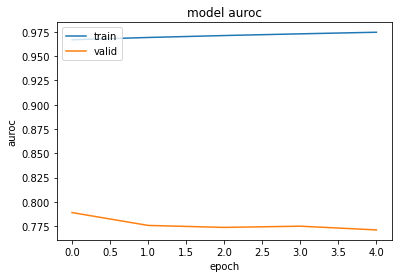

In [86]:
import matplotlib.pyplot as plt


plt.plot(history.history['auroc'])
plt.plot(history.history['val_auroc'])
plt.title('model auroc')
plt.ylabel('auroc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()